# This is the notebook were i will compare all the algorithms/change of parameters for the evolution of the structure

### Imports

In [1]:
import numpy as np
import random
import copy
import gymnasium as gym
from evogym.envs import *
from evogym import EvoWorld, EvoSim, EvoViewer, sample_robot, get_full_connectivity, is_connected
import utils
from fixed_controllers import *

# Imports to compare performances
import time
import matplotlib.pyplot as plt
import pandas as pd

## Uma lista de 5 seeds
SEED = [42,43,44,45,46]


### Utils

In [2]:
def run_experiment(algorithm, num_runs=5, num_generations=100, scenario='Walker-v0', steps=500, controller=None, algorithm_name=None):
    """
    Run an evolutionary algorithm multiple times and store key results.
    
    Parameters:
        algorithm (function): The function that runs an evolutionary algorithm (e.g., `random_search`, `differential_evolution`).
        num_runs (int): Number of times to run the algorithm.
        num_generations (int): Number of generations per run.
        scenario (str): Environment scenario.
        steps (int): Number of steps per simulation.
        controller (function): Robot controller function.

    Returns:
        best_overall_robot (EvoRobot): Best robot found across all runs.
        best_overall_fitness (float): Best fitness score found across all runs.
        mean_fitness_per_generation (np.array): Mean best fitness per generation across all runs.
        mean_fitnesses (np.array): Mean of mean fitness scores per generation.
        mean_execution_time (float): Mean execution time across all runs.
        std_fitnesses (np.array): Standard deviation of fitness scores per generation.
    """

    # Initialize storage variables
    best_fitnesses_overall = np.zeros(num_generations)  # Sum fitness scores across runs (to average later)
    mean_fitnesses = np.zeros(num_generations)  # Sum mean fitness scores across runs (to average later)
    std_fitnesses = np.zeros(num_generations)  # Sum std fitness scores across runs (to average later)
    
    total_execution_time = 0
    best_overall_fitness = float('-inf')
    best_overall_robot = None

    for i in range(num_runs):
        random.seed(SEED[i])
        np.random.seed(SEED[i])
        
        print(f"\nRunning {algorithm.__name__} {i + 1}/{num_runs}...")

        # Run the algorithm and extract results
        best_robot, best_fitness, best_fitness_scores, mean_fitnesses_run, execution_time, std_fitness_scores_run = algorithm()

        print(f"Best fitness score of run {i + 1}: {best_fitness:.3f}")

        # Accumulate fitness data for averaging
        best_fitnesses_overall += np.array(best_fitness_scores)  
        mean_fitnesses += np.array(mean_fitnesses_run)  
        std_fitnesses += np.array(std_fitness_scores_run)

        # Keep track of the best robot across all runs
        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_overall_robot = best_robot

        # Save in a csv file the results of the run
        df = pd.DataFrame({
            'Generation': range(num_generations),
            'Reward': best_fitness_scores,
            'Best Fitness': best_fitness_scores,
            'Mean Fitness': mean_fitnesses_run,
            'Std Fitness': std_fitness_scores_run,
            'Execution Time': execution_time
        })
        
        df.to_csv(f'{algorithm_name}_{scenario}_seed_{SEED[i]}.csv', index=False)
        print(f"Results of run {i + 1} saved to {algorithm_name}_{scenario}_seed_{SEED[i]}.csv")
        
        # Also save a gif of the best robot of the run
        utils.create_gif(best_robot, filename=f'{algorithm_name}_{scenario}_seed_{SEED[i]}.gif', scenario=scenario, steps=steps, controller=controller)
        
        # Accumulate execution time
        total_execution_time += execution_time

    # Compute the **mean** best fitness per generation across runs
    best_fitnesses_overall /= num_runs
    mean_fitnesses /= num_runs
    std_fitnesses /= num_runs
    mean_execution_time = total_execution_time / num_runs

    print("\nFinal Results After Multiple Runs:")
    print(f"Mean execution time: {mean_execution_time:.2f} seconds")
    print(f"Best fitness found: {best_overall_fitness:.3f}")

    # Plot averaged fitness evolution
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_generations), best_fitnesses_overall, label="Best Fitness per Generation", color='blue')
    plt.fill_between(range(num_generations), best_fitnesses_overall - std_fitnesses, best_fitnesses_overall + std_fitnesses, color='blue', alpha=0.2, label="Std Dev Range")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Score")
    plt.title(f"{algorithm_name}: Fitness Evolution in {scenario}")
    plt.legend()
    plt.grid()
    plt.show()

    # Simulate best robot
    print("\nSimulating Best Robot...")
    for _ in range(10):
        utils.simulate_best_robot(best_overall_robot, scenario=scenario, steps=steps)
            

    # Create a visualization GIF
    utils.create_gif(best_overall_robot, filename=f'{algorithm_name}_{scenario}_structure.gif', scenario=scenario, steps=steps, controller=controller)

    # Return results
    return best_overall_robot, best_overall_fitness, best_fitnesses_overall, mean_fitnesses, mean_execution_time, std_fitnesses


### 1. Random Search

In [3]:

# ---- PARAMETERS ----
NUM_GENERATIONS = 100   # Number of generations to evolve
MIN_GRID_SIZE = (5, 5)  # Minimum size of the robot grid
MAX_GRID_SIZE = (5, 5)  # Maximum size of the robot grid
STEPS = 500
SCENARIO = 'Walker-v0'

# ---- VOXEL TYPES ----
VOXEL_TYPES = [0, 1, 2, 3, 4]  # Empty, Rigid, Soft, Active (+/-)

CONTROLLER = alternating_gait

def evaluate_fitness(robot_structure, view=False):    
    try:
        connectivity = get_full_connectivity(robot_structure)
  
        env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
        env.reset()
        sim = env.sim
        viewer = EvoViewer(sim)
        viewer.track_objects('robot')
        t_reward = 0
        action_size = sim.get_dim_action_space('robot')  # Get correct action size
        for t in range(STEPS):  
            # Update actuation before stepping
            actuation = CONTROLLER(action_size,t)
            if view:
                viewer.render('screen') 
            ob, reward, terminated, truncated, info = env.step(actuation)
            t_reward += reward

            if terminated or truncated:
                env.reset()
                break

        viewer.close()
        env.close()
        return t_reward
    except (ValueError, IndexError) as e:
        return 0.0


def create_random_robot():
    """Generate a valid random robot structure."""
    
    grid_size = (random.randint(MIN_GRID_SIZE[0], MAX_GRID_SIZE[0]), random.randint(MIN_GRID_SIZE[1], MAX_GRID_SIZE[1])) # Ou seja, um numero aleatorio entre 5 e 5 ???????
    random_robot, _ = sample_robot(grid_size)
    return random_robot

def random_search():
    """Perform a random search to find the best robot structure."""
    best_robot = None
    best_fitness = -float('inf')
    fitness_history = []
    mean_fitness_history = []
    std_fitness_history = []
    
    start_time = time.time()
    
    for it in range(NUM_GENERATIONS):
        robot = create_random_robot() 
        fitness_score = evaluate_fitness(robot)
        fitness_history.append(fitness_score)
        std_fitness_history.append(np.std(fitness_history))
        mean_fitness_history.append(np.mean(fitness_history))
        
        if fitness_score > best_fitness:
            best_fitness = fitness_score
            best_robot = robot
        
        # print(f"Iteration {it + 1}: Fitness = {fitness_score:.3f}")
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    
    return best_robot, best_fitness, fitness_history, mean_fitness_history , execution_time, std_fitness_history



Running random_search 1/5...
Best fitness score of run 1: 1.435
Results of run 1 saved to random_search_Walker-v0_seed_42.csv

Running random_search 2/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 1.730
Results of run 2 saved to random_search_Walker-v0_seed_43.csv

Running random_search 3/5...
Best fitness score of run 3: 1.056
Results of run 3 saved to random_search_Walker-v0_seed_44.csv

Running random_search 4/5...
Best fitness score of run 4: 1.375
Results of run 4 saved to random_search_Walker-v0_seed_45.csv

Running random_search 5/5...
Best fitness score of run 5: 1.070
Results of run 5 saved to random_search_Walker-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 183.89 seconds
Best fitness found: 1.730


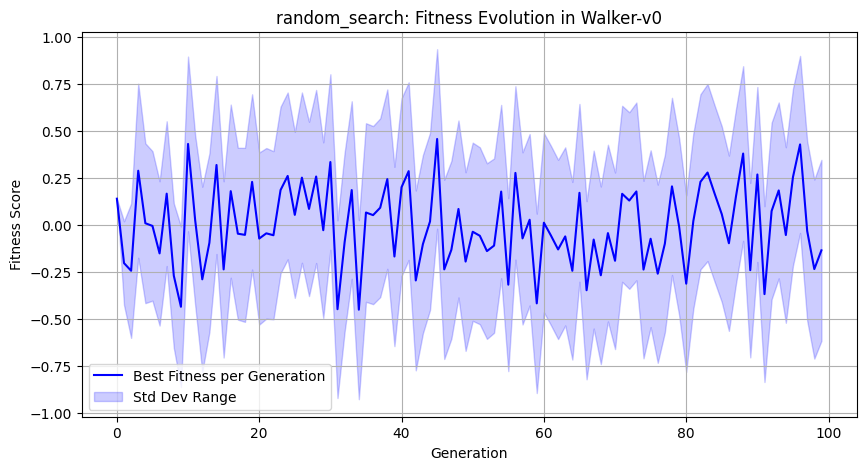


Simulating Best Robot...
Random Search results saved to random_search_results.csv

Running random_search 1/5...
Best fitness score of run 1: 1.435
Results of run 1 saved to random_search_BridgeWalker-v0_seed_42.csv

Running random_search 2/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 1.730
Results of run 2 saved to random_search_BridgeWalker-v0_seed_43.csv

Running random_search 3/5...
Best fitness score of run 3: 1.056
Results of run 3 saved to random_search_BridgeWalker-v0_seed_44.csv

Running random_search 4/5...
Best fitness score of run 4: 1.375
Results of run 4 saved to random_search_BridgeWalker-v0_seed_45.csv

Running random_search 5/5...
Best fitness score of run 5: 1.070
Results of run 5 saved to random_search_BridgeWalker-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 175.65 seconds
Best fitness found: 1.730


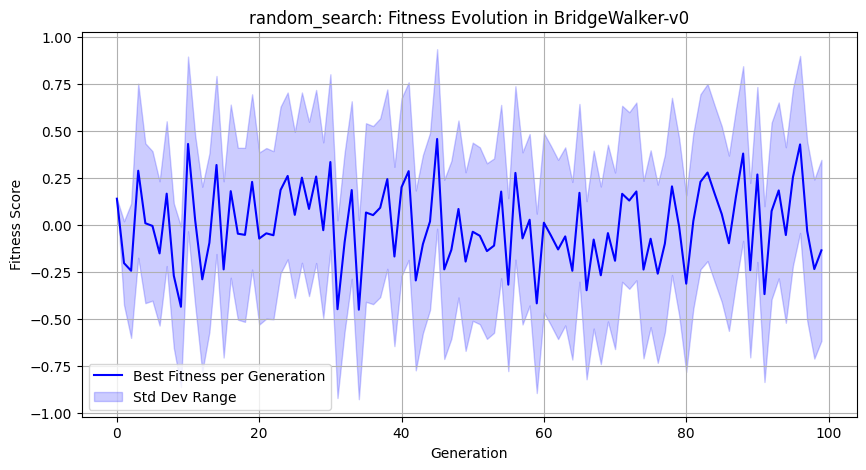


Simulating Best Robot...
Random Search results for BridgeWalker saved to random_search_results_bridge.csv


In [4]:
# Run the random search algorithm
best_robot_random, best_fitness_random, best_fitnesses_random, mean_fitness_random , mean_execution_time_random, std_fitness_random = run_experiment(random_search, num_generations=NUM_GENERATIONS, scenario=SCENARIO, steps=STEPS, controller=CONTROLLER, algorithm_name='random_search')

# save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_random)),
    'Reward': best_fitnesses_random,
    'Best Fitness': best_fitnesses_random,
    'Mean Fitness': mean_fitness_random,
    'Std Fitness': std_fitness_random,
    'Execution Time': mean_execution_time_random
})

df.to_csv('random_search_results.csv', index=False)
print("Random Search results saved to random_search_results.csv")

# Run for the other scenario
best_robot_random_bridge, best_fitness_random_bridge, best_fitnesses_random_bridge, mean_fitness_random_bridge, mean_execution_time_random_bridge, std_fitness_bridge_random = run_experiment(random_search, num_generations=NUM_GENERATIONS, scenario='BridgeWalker-v0', steps=STEPS, controller=CONTROLLER, algorithm_name='random_search')

# save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_random_bridge)),
    'Reward': best_fitnesses_random_bridge,
    'Best Fitness': best_fitnesses_random_bridge,
    'Mean Fitness': mean_fitness_random_bridge,
    'Std Fitness': std_fitness_bridge_random,
    'Execution Time': mean_execution_time_random_bridge
})

df.to_csv('random_search_results_bridge.csv', index=False)
print("Random Search results for BridgeWalker saved to random_search_results_bridge.csv")

### 2. Evolutionary Strategy

In [5]:

# ---- PARAMETERS ----
MU = 20               # Number of parents
LAMBDA = 20           # Number of offspring per generation
NUM_GENERATIONS = 100  # Number of generations
MUTATION_RATE = 0.1   # Mutation probability per voxel
STEPS = 500
SCENARIO = 'Walker-v0'

VOXEL_TYPES = [0, 1, 2, 3, 4]  # Empty, Rigid, Soft, Active (+/-)
CONTROLLER = alternating_gait  # Fixed controller

def evaluate_fitness(robot_structure, view=False):
    """Evaluate the fitness of a given robot structure."""
    try:
        connectivity = get_full_connectivity(robot_structure)
        env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
        env.reset()
        sim = env.sim
        viewer = EvoViewer(sim)
        viewer.track_objects('robot')
        t_reward = 0
        action_size = sim.get_dim_action_space('robot')

        for t in range(STEPS):
            actuation = CONTROLLER(action_size, t)
            if view:
                viewer.render('screen')
            _, reward, terminated, truncated, _ = env.step(actuation)
            t_reward += reward
            if terminated or truncated:
                break
            
        viewer.close()
        env.close()
        return t_reward
    except:
        return 0.0  # Invalid robots get zero fitness

def create_random_robot():
    """Generate a random valid robot structure."""
    grid_size = (5, 5)
    robot, _ = sample_robot(grid_size)
    return robot

def mutate(robot):
    """Apply mutation to the robot's structure."""
    new_robot = copy.deepcopy(robot)
    for i in range(new_robot.shape[0]):
        for j in range(new_robot.shape[1]):
            if random.random() < MUTATION_RATE:
                new_robot[i, j] = random.choice(VOXEL_TYPES)
    return new_robot if is_connected(new_robot) else robot  # Ensure connectivity

def evolution_strategy():
    """Run the (μ + λ) Evolution Strategy to optimize robot structures."""
    population = [create_random_robot() for _ in range(MU)]  # Initialize μ parents
    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    start_time = time.time()  # Start time tracking

    for generation in range(NUM_GENERATIONS):
        # Evaluate parents
        fitnesses = [evaluate_fitness(robot) for robot in population]
        
        # Record fitness statistics
        best_fitness_scores.append(max(fitnesses))
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        # Generate λ offspring through mutation only
        offspring = [mutate(random.choice(population)) for _ in range(LAMBDA)]
        
        # Avaliate offspring
        offspring_fitnesses = [evaluate_fitness(robot) for robot in offspring]

        # Combine parents and offspring
        combined_population = population + offspring
        combined_fitnesses = fitnesses + offspring_fitnesses

        # Select the top μ individuals for the next generation
        sorted_indices = np.argsort(combined_fitnesses)[-MU:]  # Top μ individuals
        population = [combined_population[i] for i in sorted_indices]

        # print(f"Generation {generation + 1}: Best Fitness = {best_fitness_scores[-1]:.3f}, Mean Fitness = {mean_fitness_scores[-1]:.3f}")

    end_time = time.time()  # End time tracking
    execution_time = end_time - start_time

    return population[np.argmax(fitnesses)], max(fitnesses), best_fitness_scores, mean_fitness_scores , execution_time, std_fitness_scores




Running evolution_strategy 1/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE.

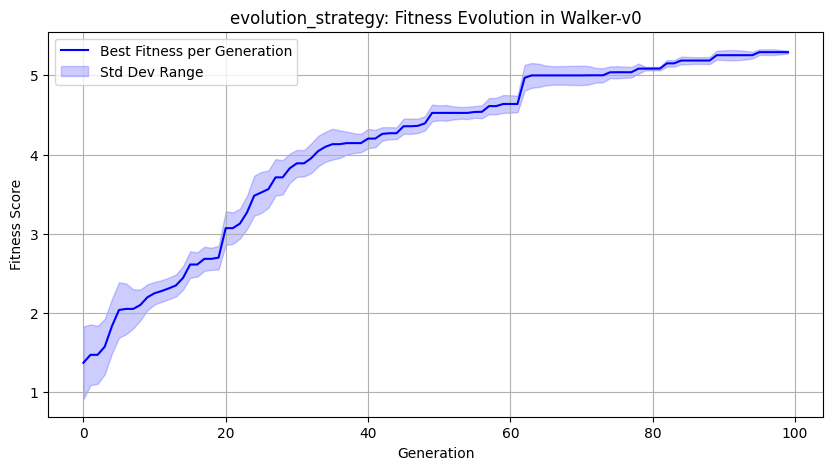


Simulating Best Robot...

Running evolution_strategy 1/5...
Best fitness score of run 1: 6.495

Running evolution_strategy 2/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 7.916

Running evolution_strategy 3/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 3: 6.891

Running evolution_strategy 4/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 5.413

Running evolution_strategy 5/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 5: 4.865

Final Results After Multiple Runs:
Mean execution time: 7190.05 seconds
Best fitness found: 7.916


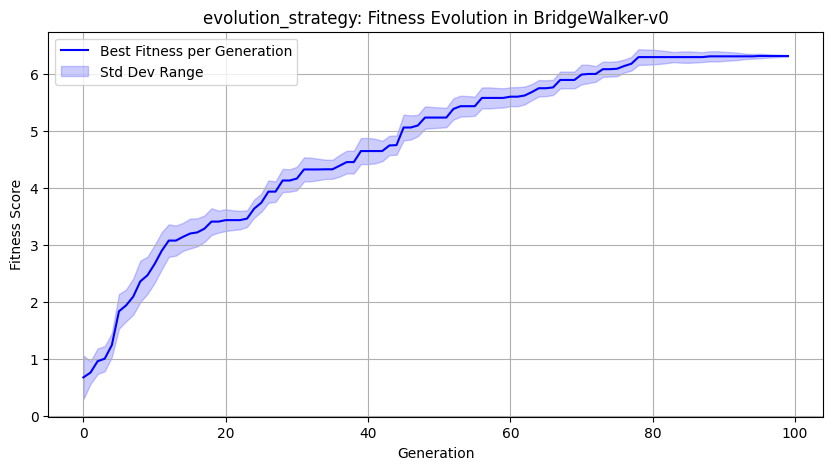


Simulating Best Robot...


In [ ]:
# Run the evolutionary strategy algorithm
best_robot_evolution, best_fitness_evolution, best_fitnesses_evolution, mean_fitnesses_evolution, execution_time_evolution, std_fitness_scores_evolution = run_experiment(evolution_strategy, num_generations=NUM_GENERATIONS, scenario=SCENARIO, steps=STEPS, controller=CONTROLLER, algorithm_name='evolution_strategy')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_evolution)),
    'Reward': best_fitnesses_evolution,
    'Best Fitness': best_fitnesses_evolution,
    'Mean Fitness': mean_fitnesses_evolution,
    'Std Fitness': std_fitness_scores_evolution,
    'Execution Time': execution_time_evolution
})

df.to_csv('evolution_strategy_results.csv', index=False)
print("Evolution Strategy results saved to evolution_strategy_results.csv")

# Run for the other scenario
best_robot_evolution_bridge, best_fitness_evolution_bridge, best_fitnesses_evolution_bridge, mean_fitnesses_evolution_bridge, execution_time_evolution_bridge, std_fitness_scores_evolution_bridge = run_experiment(evolution_strategy, num_generations=NUM_GENERATIONS, scenario='BridgeWalker-v0', steps=STEPS, controller=CONTROLLER, algorithm_name='evolution_strategy')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_evolution_bridge)),
    'Reward': best_fitnesses_evolution_bridge,
    'Best Fitness': best_fitnesses_evolution_bridge,
    'Mean Fitness': mean_fitnesses_evolution_bridge,
    'Std Fitness': std_fitness_scores_evolution_bridge,
    'Execution Time': execution_time_evolution_bridge
})

df.to_csv('evolution_strategy_results_bridge.csv', index=False)
print("Evolution Strategy results for BridgeWalker saved to evolution_strategy_results_bridge.csv")

### 3. Genetic Algorithm

In [3]:

# ---- PARAMETERS ----
POP_SIZE = 40        # Population size
NUM_GENERATIONS = 100  # Number of generations
MUTATION_RATE = 0.1  # Probability of mutation per voxel
ELITE_RATIO = 0.2    # Percentage of best individuals to keep
STEPS = 500
SCENARIO = 'Walker-v0'

# ---- VOXEL TYPES ----
VOXEL_TYPES = [0, 1, 2, 3, 4]  # Empty, Rigid, Soft, Active (+/-)

CONTROLLER = alternating_gait  # Fixed controller

def evaluate_fitness(robot_structure, view=False):
    """Evaluate the fitness of a given robot structure."""
    try:
        connectivity = get_full_connectivity(robot_structure)
        env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
        env.reset()
        sim = env.sim
        viewer = EvoViewer(sim)
        viewer.track_objects('robot')
        t_reward = 0
        action_size = sim.get_dim_action_space('robot') # Get correct action size

        for t in range(STEPS):
            # Update actuation before stepping
            actuation = CONTROLLER(action_size, t)
            if view:
                viewer.render('screen')
            ob, reward, terminated, truncated, info = env.step(actuation)
            t_reward += reward

            if terminated or truncated:
                break
            
        viewer.close()
        env.close()
        return t_reward
    except:
        return 0.0  # Invalid robots get zero fitness

def create_random_robot():
    """Generate a random valid robot structure."""
    grid_size = (5, 5)
    robot, _ = sample_robot(grid_size)
    return robot

# This may be the reason why the code is so slow
def mutate(robot):
    """Mutate a robot's structure by randomly changing voxels."""
    """Point mutation"""
    new_robot = copy.deepcopy(robot)
    for i in range(new_robot.shape[0]):
        for j in range(new_robot.shape[1]):
            if random.random() < MUTATION_RATE: # We have a 10% chance of mutation
                new_robot[i, j] = random.choice(VOXEL_TYPES)
    return new_robot if is_connected(new_robot) else robot  # Ensure connectivity, otherwise return original

# This may be the reason why the code is so slow
def crossover(parent1, parent2):
    """Perform crossover between two parent robots."""
    """Uniform crossover"""
    child = copy.deepcopy(parent1)
    for i in range(child.shape[0]):
        for j in range(child.shape[1]):
            if random.random() < 0.5: # 50% chance of inheriting from parent2
                child[i, j] = parent2[i, j]
    return child if is_connected(child) else parent1  # Ensure connectivity

def select_parents(population, fitnesses):
    """Select parents using tournament selection."""
    """Tournament selection"""
    tournament_size = 3
    parents = []
    for _ in range(len(population)):
        competitors = random.sample(list(zip(population, fitnesses)), tournament_size)
        best = max(competitors, key=lambda x: x[1])[0]
        parents.append(best)
    return parents

def genetic_algorithm():
    """Run the evolutionary algorithm to evolve the best robot structure."""
    # Initialize population
    population = [create_random_robot() for _ in range(POP_SIZE)]
    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []
    
    start_time = time.time()  # Start measuring time

    for generation in range(NUM_GENERATIONS):
        # Evaluate fitness
        fitnesses = [evaluate_fitness(robot) for robot in population]
        best_idx = np.argmax(fitnesses)
        
        # Record fitness values for plotting
        best_fitness_scores.append(fitnesses[best_idx])
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        # Report progress
        # print(f"Generation {generation + 1}: Best Fitness = {fitnesses[best_idx]:.3f}, Mean Fitness = {np.mean(fitnesses):.3f}")

        # Select top individuals (elitism)
        num_elites = int(ELITE_RATIO * POP_SIZE)
        elites = [population[i] for i in np.argsort(fitnesses)[-num_elites:]]

        # Select parents and create offspring
        parents = select_parents(population, fitnesses)
        offspring = [crossover(random.choice(parents), random.choice(parents)) for _ in range(POP_SIZE - num_elites)]
        
        # Apply mutation
        offspring = [mutate(child) for child in offspring]

        # Form the new population
        population = elites + offspring
    
    end_time = time.time()  # End time measurement
    execution_time = end_time - start_time

    return population[np.argmax(fitnesses)], max(fitnesses), best_fitness_scores, mean_fitness_scores, execution_time, std_fitness_scores



Running genetic_algorithm 1/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 5.805

Running genetic_algorithm 2/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 5.014

Running genetic_algorithm 3/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 3: 4.910

Running genetic_algorithm 4/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 6.764

Running genetic_algorithm 5/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 5: 5.436

Final Results After Multiple Runs:
Mean execution time: 6938.56 seconds
Best fitness found: 6.764


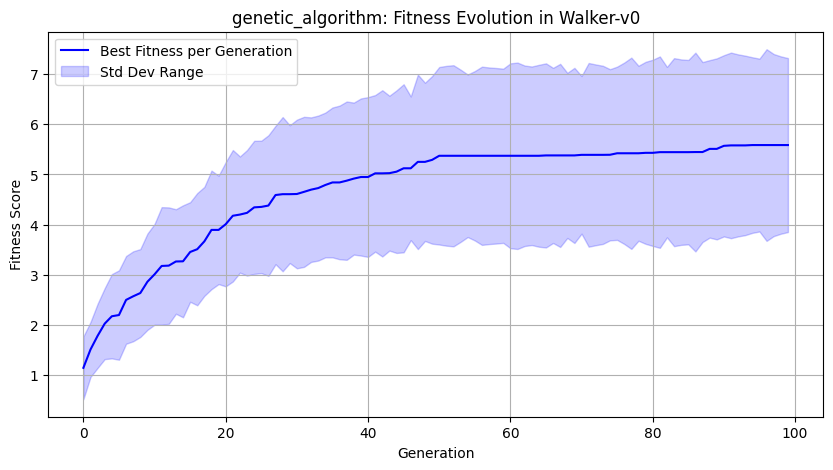


Simulating Best Robot...

Running genetic_algorithm 1/5...
Best fitness score of run 1: 6.571

Running genetic_algorithm 2/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 7.644

Running genetic_algorithm 3/5...
Best fitness score of run 3: 6.183

Running genetic_algorithm 4/5...
Best fitness score of run 4: 7.377

Running genetic_algorithm 5/5...
Best fitness score of run 5: 7.961

Final Results After Multiple Runs:
Mean execution time: 6846.75 seconds
Best fitness found: 7.961


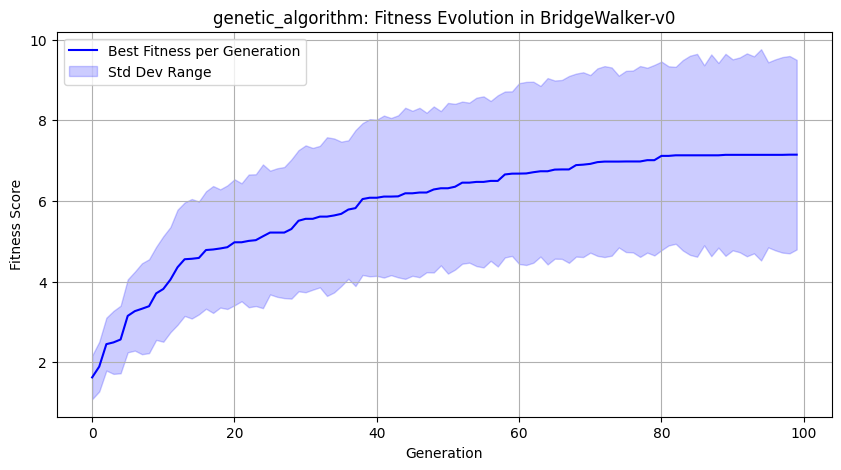


Simulating Best Robot...


In [ ]:
# Run the genetic algorithm
best_robot_genetic, best_fitness_genetic, best_fitnesses_genetic, mean_fitnesses_genetic, execution_time_genetic, std_fitness_scores_genetic = run_experiment(genetic_algorithm, num_generations=NUM_GENERATIONS, scenario=SCENARIO, steps=STEPS, controller=CONTROLLER, algorithm_name='genetic_algorithm')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_genetic)),
    'Reward': best_fitnesses_genetic,
    'Best Fitness': best_fitnesses_genetic,
    'Mean Fitness': mean_fitnesses_genetic,
    'Std Fitness': std_fitness_scores_genetic,
    'Execution Time': execution_time_genetic
})

df.to_csv('genetic_algorithm_results.csv', index=False)
print("Genetic Algorithm results saved to genetic_algorithm_results.csv")

# Run for the other scenario
best_robot_genetic_bridge, best_fitness_genetic_bridge, best_fitnesses_genetic_bridge, mean_fitnesses_genetic_bridge, execution_time_genetic_bridge, std_fitness_scores_genetic_bridge = run_experiment(genetic_algorithm, num_generations=NUM_GENERATIONS, scenario='BridgeWalker-v0', steps=STEPS, controller=CONTROLLER, algorithm_name='genetic_algorithm')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_genetic_bridge)),
    'Reward': best_fitnesses_genetic_bridge,
    'Best Fitness': best_fitnesses_genetic_bridge,
    'Mean Fitness': mean_fitnesses_genetic_bridge,
    'Std Fitness': std_fitness_scores_genetic_bridge,
    'Execution Time': execution_time_genetic_bridge
})

df.to_csv('genetic_algorithm_results_bridge.csv', index=False)
print("Genetic Algorithm results for BridgeWalker saved to genetic_algorithm_results_bridge.csv")

### ES vs GA vs Random

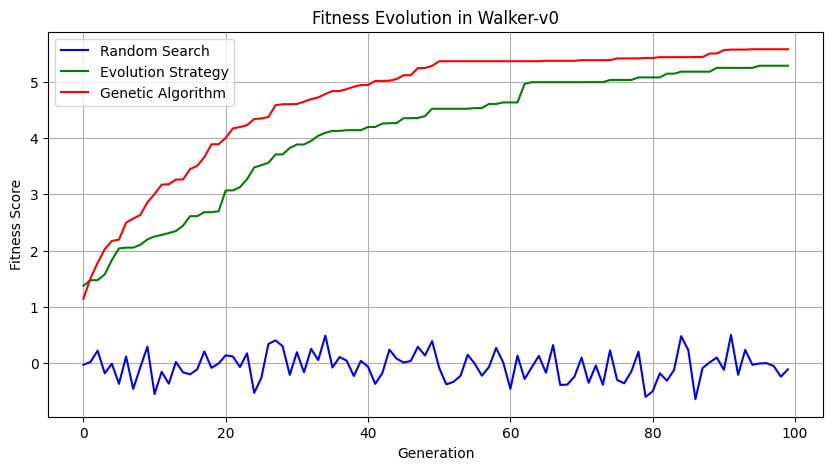

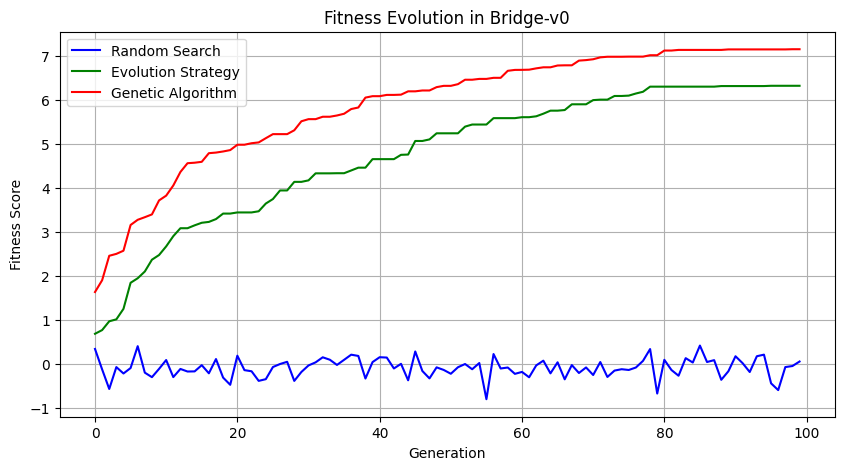

Execution times:
Random Search: 174.92 seconds
Evolution Strategy: 6854.23 seconds
Genetic Algorithm: 6938.56 seconds


Best fitness scores:
Random Search: 1.725
Evolution Strategy: 7.746
Genetic Algorithm: 6.764




In [22]:
# Lets plot the results
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_GENERATIONS), best_fitnesses_random, label="Random Search", color='blue')
plt.plot(range(NUM_GENERATIONS), best_fitnesses_evolution, label="Evolution Strategy", color='green')
plt.plot(range(NUM_GENERATIONS), best_fitnesses_genetic, label="Genetic Algorithm", color='red')
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title(f"Fitness Evolution in {SCENARIO}")
plt.legend()
plt.grid()
plt.show()

# Plot the results for the other scenario
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_GENERATIONS), best_fitnesses_random_bridge, label="Random Search", color='blue')
plt.plot(range(NUM_GENERATIONS), best_fitnesses_evolution_bridge, label="Evolution Strategy", color='green')
plt.plot(range(NUM_GENERATIONS), best_fitnesses_genetic_bridge, label="Genetic Algorithm", color='red')
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Fitness Evolution in Bridge-v0")
plt.legend()
plt.grid()
plt.show()

# Print the execution times
print("Execution times:")
print(f"Random Search: {mean_execution_time_random:.2f} seconds")
print(f"Evolution Strategy: {execution_time_evolution:.2f} seconds")
print(f"Genetic Algorithm: {execution_time_genetic:.2f} seconds")
print("\n")

# Print the best fitness scores found
print("Best fitness scores:")
print(f"Random Search: {best_fitness_random:.3f}")
print(f"Evolution Strategy: {best_fitness_evolution:.3f}")
print(f"Genetic Algorithm: {best_fitness_genetic:.3f}")
print("\n")

### GA vs GA with high mutation
I expect to have almost same resulst, but the with high mutation i assume the generation will have more variaty.... wich means, more std in each generation


Running genetic_algorithm 1/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 4.315

Running genetic_algorithm 2/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 4.621

Running genetic_algorithm 3/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 3: 4.927

Running genetic_algori

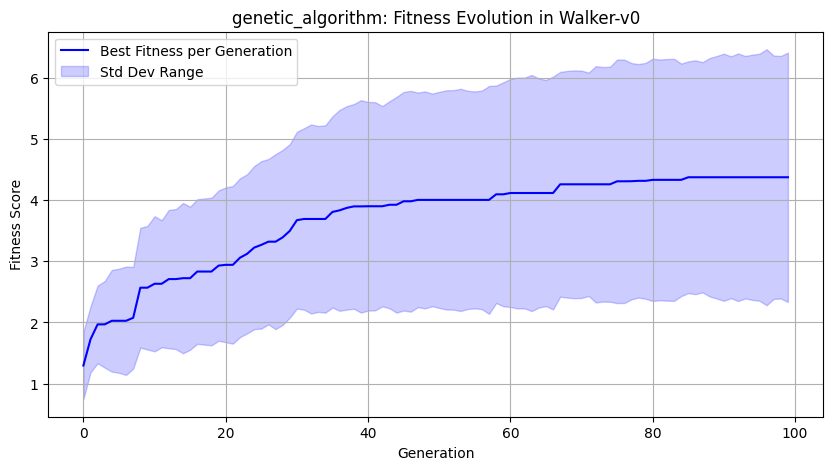


Simulating Best Robot...

Running genetic_algorithm 1/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 7.013

Running genetic_algorithm 2/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 4.412

Running genetic_algorithm 3/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 3: 4.781

Running genetic_algorithm 4/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 4.912

Running genetic_algorithm 5/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 5: 3.804

Final Results After Multiple Runs:
Mean execution time: 7097.10 seconds
Best fitness found: 7.013


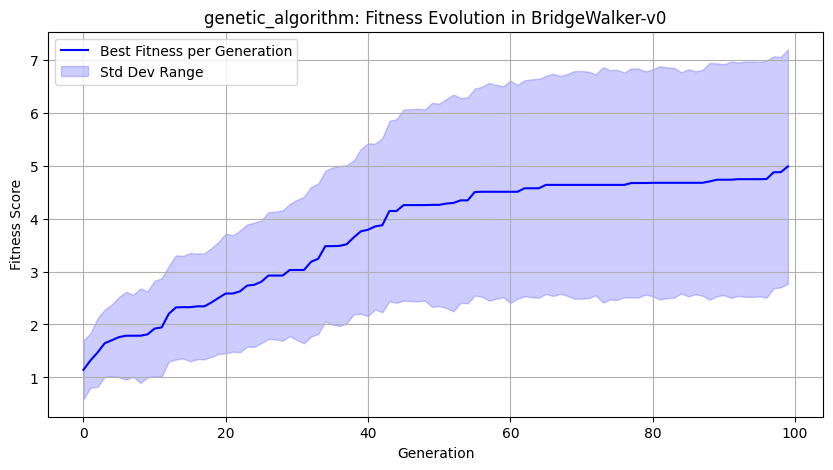


Simulating Best Robot...


In [ ]:
MUTATION_RATE = 0.5  # Probability of mutation per voxel

# Run the genetic algorithm with a higher mutation rate
best_robot_genetic_high_mut, best_fitness_genetic_high_mut, best_fitnesses_genetic_high_mut, mean_fitnesses_genetic_high_mut, execution_time_genetic_high_mut, std_fitness_genetic_high_mut = run_experiment(genetic_algorithm, num_generations=NUM_GENERATIONS, scenario=SCENARIO, steps=STEPS, controller=CONTROLLER, algorithm_name='genetic_algorithm_high_mut')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_genetic_high_mut)),
    'Reward': best_fitnesses_genetic_high_mut,
    'Best Fitness': best_fitnesses_genetic_high_mut,
    'Mean Fitness': mean_fitnesses_genetic_high_mut,
    'Std Fitness': std_fitness_genetic_high_mut,
    'Execution Time': execution_time_genetic_high_mut
})

df.to_csv('genetic_algorithm_high_mut_results.csv', index=False)
print("Genetic Algorithm with High Mutation results saved to genetic_algorithm_high_mut_results.csv")

# Run for the other scenario
best_robot_genetic_high_mut_bridge, best_fitness_genetic_high_mut_bridge, best_fitnesses_genetic_high_mut_bridge, mean_fitnesses_genetic_high_mut_bridge, execution_time_genetic_high_mut_bridge, std_fitness_genetic_high_mut_bridge = run_experiment(genetic_algorithm, num_generations=NUM_GENERATIONS, scenario='BridgeWalker-v0', steps=STEPS, controller=CONTROLLER, algorithm_name='genetic_algorithm_high_mut')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_genetic_high_mut_bridge)),
    'Reward': best_fitnesses_genetic_high_mut_bridge,
    'Best Fitness': best_fitnesses_genetic_high_mut_bridge,
    'Mean Fitness': mean_fitnesses_genetic_high_mut_bridge,
    'Std Fitness': std_fitness_genetic_high_mut_bridge,
    'Execution Time': execution_time_genetic_high_mut_bridge
})

df.to_csv('genetic_algorithm_high_mut_results_bridge.csv', index=False)
print("Genetic Algorithm with High Mutation results for BridgeWalker saved to genetic_algorithm_high_mut_results_bridge.csv")

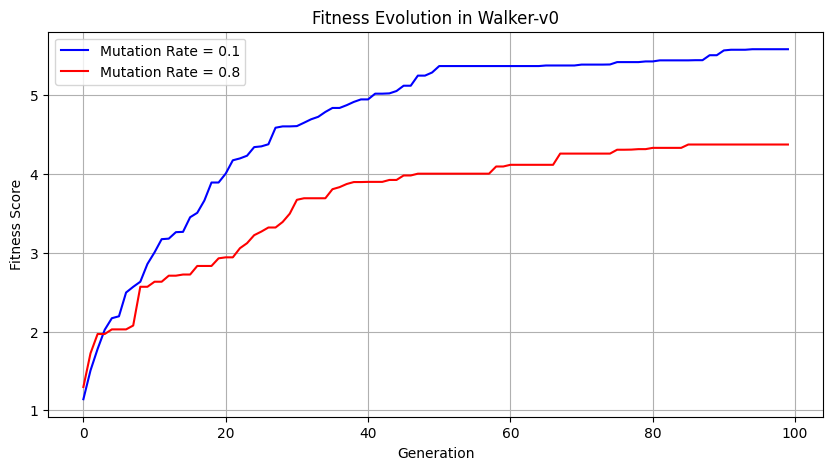

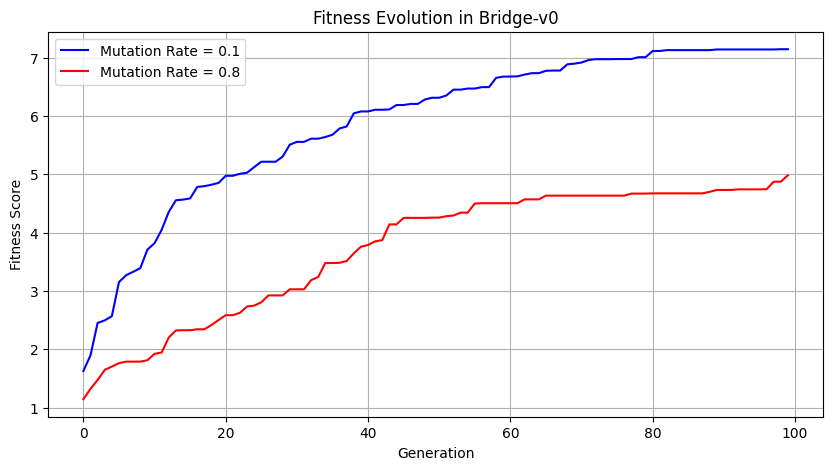

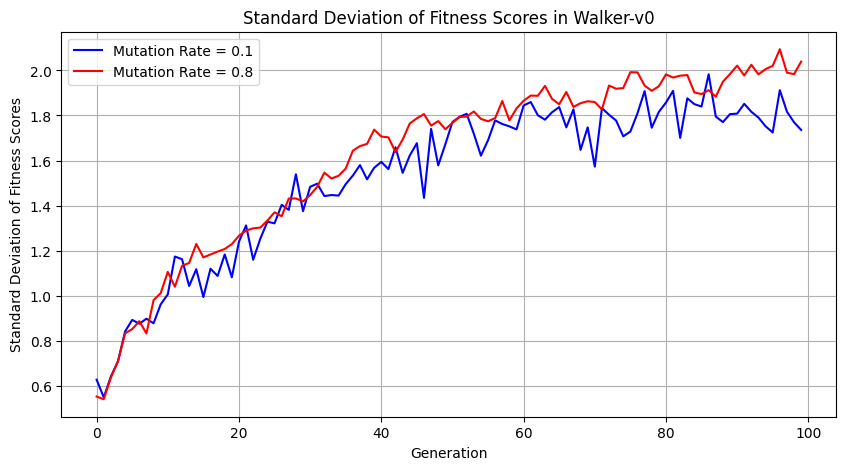

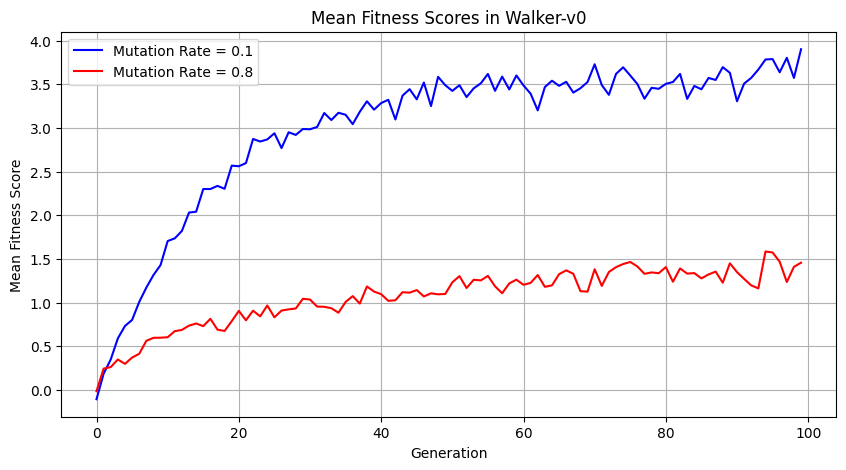

Execution times:
Mutation Rate = 0.1: 6938.56 seconds
Mutation Rate = 0.8: 7141.34 seconds


Best fitness scores:
Mutation Rate = 0.1: 6.764
Mutation Rate = 0.8: 4.927




In [ ]:
# Lets plot the results
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_GENERATIONS), best_fitnesses_genetic, label="Mutation Rate = 0.1", color='blue')
plt.plot(range(NUM_GENERATIONS), best_fitnesses_genetic_high_mut, label="Mutation Rate = 0.5", color='red')
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title(f"Fitness Evolution in {SCENARIO}")
plt.legend()
plt.grid()
plt.show()

# Plot the results for the other scenario
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_GENERATIONS), best_fitnesses_genetic_bridge, label="Mutation Rate = 0.1", color='blue')
plt.plot(range(NUM_GENERATIONS), best_fitnesses_genetic_high_mut_bridge, label="Mutation Rate = 0.5", color='red')
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Fitness Evolution in Bridge-v0")
plt.legend()
plt.grid()
plt.show()

# Plot the std
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_GENERATIONS), std_fitness_scores_genetic, label="Mutation Rate = 0.1", color='blue')
plt.plot(range(NUM_GENERATIONS), std_fitness_genetic_high_mut, label="Mutation Rate = 0.5", color='red')
plt.xlabel("Generation")
plt.ylabel("Standard Deviation of Fitness Scores")
plt.title("Standard Deviation of Fitness Scores in Walker-v0")
plt.legend()
plt.grid()
plt.show()

# Plot the mean fitness scores
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_GENERATIONS), mean_fitnesses_genetic, label="Mutation Rate = 0.1", color='blue')
plt.plot(range(NUM_GENERATIONS), mean_fitnesses_genetic_high_mut, label="Mutation Rate = 0.5", color='red')
plt.xlabel("Generation")
plt.ylabel("Mean Fitness Score")
plt.title("Mean Fitness Scores in Walker-v0")
plt.legend()
plt.grid()
plt.show()

# Print the execution times
print("Execution times:")
print(f"Mutation Rate = 0.1: {execution_time_genetic:.2f} seconds")
print(f"Mutation Rate = 0.5: {execution_time_genetic_high_mut:.2f} seconds")
print("\n")

# Print the best fitness scores found
print("Best fitness scores:")
print(f"Mutation Rate = 0.1: {best_fitness_genetic:.3f}")
print(f"Mutation Rate = 0.5: {best_fitness_genetic_high_mut:.3f}")
print("\n")

### GA vs GA with lower pop size and more generations
I believe that the last one will be worse, because ga its meant for generations that have bigger pop size...


Running genetic_algorithm 1/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 8.532

Running genetic_algorithm 2/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 6.256

Running genetic_algorithm 3/5...
Best fitness score of run 3: 4.936

Running genetic_algorithm 4/5...
Best fitness score of run 4: 6.052

Running genetic_algorithm 5/5...
Best fitness score of run 5: 5.382

Final Results After Multiple Runs:
Mean execution time: 6768.26 seconds
Best fitness found: 8.532


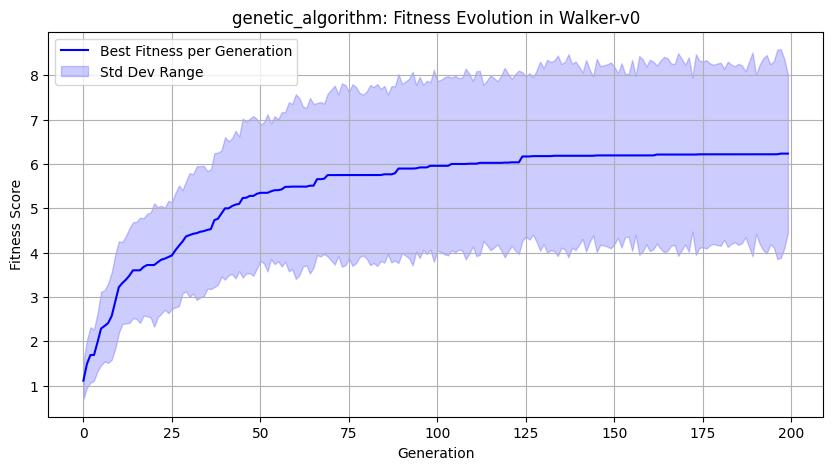


Simulating Best Robot...

Running genetic_algorithm 1/5...
Best fitness score of run 1: 4.691

Running genetic_algorithm 2/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 6.750

Running genetic_algorithm 3/5...
Best fitness score of run 3: 7.668

Running genetic_algorithm 4/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 5.237

Running genetic_algorithm 5/5...
Best fitness score of run 5: 5.723

Final Results After Multiple Runs:
Mean execution time: 7029.97 seconds
Best fitness found: 7.668


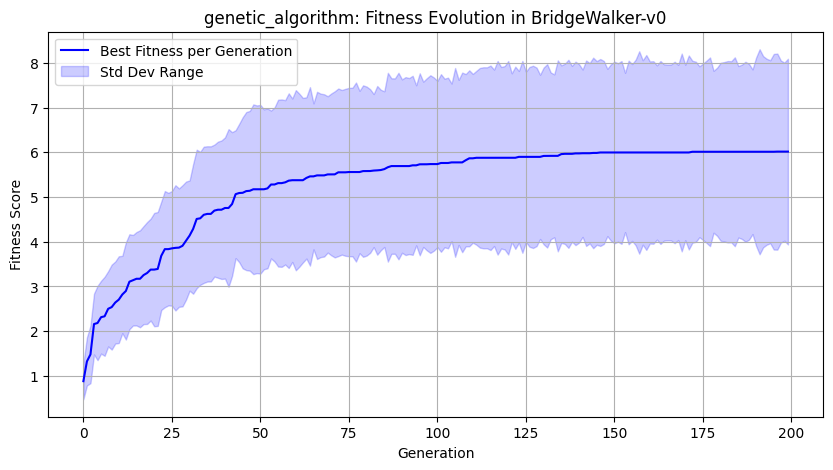


Simulating Best Robot...


In [ ]:
NUM_GENERATIONS = 200
POP_SIZE = 20
MUTATION_RATE = 0.1

# Run the genetic algorithm with a higher generation count
best_robot_genetic_high_gen, best_fitness_genetic_high_gen, best_fitnesses_genetic_high_gen, mean_fitnesses_genetic_high_gen, execution_time_genetic_high_gen, std_fitness_scores_genetic_high_gen = run_experiment(genetic_algorithm, num_generations=NUM_GENERATIONS, scenario=SCENARIO, steps=STEPS, controller=CONTROLLER, algorithm_name='genetic_algorithm_high_gen')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_genetic_high_gen)),
    'Reward': best_fitnesses_genetic_high_gen,
    'Best Fitness': best_fitnesses_genetic_high_gen,
    'Mean Fitness': mean_fitnesses_genetic_high_gen,
    'Std Fitness': std_fitness_scores_genetic_high_gen,
    'Execution Time': execution_time_genetic_high_gen
})

df.to_csv('genetic_algorithm_high_gen_results.csv', index=False)
print("Genetic Algorithm with High Generations results saved to genetic_algorithm_high_gen_results.csv")

# Run for the other scenario
best_robot_genetic_high_gen_bridge, best_fitness_genetic_high_gen_bridge, best_fitnesses_genetic_high_gen_bridge, mean_fitnesses_genetic_high_gen_bridge, execution_time_genetic_high_gen_bridge, std_fitness_scores_genetic_high_gen_bridge = run_experiment(genetic_algorithm, num_generations=NUM_GENERATIONS, scenario='BridgeWalker-v0', steps=STEPS, controller=CONTROLLER, algorithm_name='genetic_algorithm_high_gen')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_genetic_high_gen_bridge)),
    'Reward': best_fitnesses_genetic_high_gen_bridge,
    'Best Fitness': best_fitnesses_genetic_high_gen_bridge,
    'Mean Fitness': mean_fitnesses_genetic_high_gen_bridge,
    'Std Fitness': std_fitness_scores_genetic_high_gen_bridge,
    'Execution Time': execution_time_genetic_high_gen_bridge
})

df.to_csv('genetic_algorithm_high_gen_results_bridge.csv', index=False)
print("Genetic Algorithm with High Generations results for BridgeWalker saved to genetic_algorithm_high_gen_results_bridge.csv")

## Compare GA with the differente fixed controlers: (alternating_gait, sinusoidal_wave, hopping_motion)

In [ ]:
NUM_GENERATIONS = 100
POP_SIZE = 40

CONTROLLER = sinusoidal_wave

# Run the genetic algorithm with a different controller
best_robot_genetic_sin, best_fitness_genetic_sin, best_fitnesses_genetic_sin, mean_fitnesses_genetic_sin, execution_time_genetic_sin, std_fitness_scores_genetic_sin = run_experiment(genetic_algorithm, num_generations=NUM_GENERATIONS, scenario=SCENARIO, steps=STEPS, controller=CONTROLLER, algorithm_name='genetic_algorithm_sin')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_genetic_sin)),
    'Reward': best_fitnesses_genetic_sin,
    'Best Fitness': best_fitnesses_genetic_sin,
    'Mean Fitness': mean_fitnesses_genetic_sin,
    'Std Fitness': std_fitness_scores_genetic_sin,
    'Execution Time': execution_time_genetic_sin
})

df.to_csv('genetic_algorithm_sin_results.csv', index=False)
print("Genetic Algorithm with Sinusoidal Wave results saved to genetic_algorithm_sin_results.csv")

# Run for the other scenario
best_robot_genetic_sin_bridge, best_fitness_genetic_sin_bridge, best_fitnesses_genetic_sin_bridge, mean_fitnesses_genetic_sin_bridge, execution_time_genetic_sin_bridge, std_fitness_scores_genetic_sin_bridge = run_experiment(genetic_algorithm, num_generations=NUM_GENERATIONS, scenario='BridgeWalker-v0', steps=STEPS, controller=CONTROLLER, algorithm_name='genetic_algorithm_sin')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_genetic_sin_bridge)),
    'Reward': best_fitnesses_genetic_sin_bridge,
    'Best Fitness': best_fitnesses_genetic_sin_bridge,
    'Mean Fitness': mean_fitnesses_genetic_sin_bridge,
    'Std Fitness': std_fitness_scores_genetic_sin_bridge,
    'Execution Time': execution_time_genetic_sin_bridge
})
df.to_csv('genetic_algorithm_sin_results_bridge.csv', index=False)
print("Genetic Algorithm with Sinusoidal Wave results for BridgeWalker saved to genetic_algorithm_sin_results_bridge.csv")

#################################################

CONTROLLER = hopping_motion

# Run the genetic algorithm with a different controller
best_robot_genetic_hop, best_fitness_genetic_hop, best_fitnesses_genetic_hop, mean_fitnesses_genetic_hop, execution_time_genetic_hop, std_fitness_scores_genetic_hop = run_experiment(genetic_algorithm, num_generations=NUM_GENERATIONS, scenario=SCENARIO, steps=STEPS, controller=CONTROLLER, algorithm_name='genetic_algorithm_hop')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_genetic_hop)),
    'Reward': best_fitnesses_genetic_hop,
    'Best Fitness': best_fitnesses_genetic_hop,
    'Mean Fitness': mean_fitnesses_genetic_hop,
    'Std Fitness': std_fitness_scores_genetic_hop,
    'Execution Time': execution_time_genetic_hop
})

df.to_csv('genetic_algorithm_hop_results.csv', index=False)
print("Genetic Algorithm with Hopping Motion results saved to genetic_algorithm_hop_results.csv")

# Run for the other scenario
best_robot_genetic_hop_bridge, best_fitness_genetic_hop_bridge, best_fitnesses_genetic_hop_bridge, mean_fitnesses_genetic_hop_bridge, execution_time_genetic_hop_bridge, std_fitness_scores_genetic_hop_bridge = run_experiment(genetic_algorithm, num_generations=NUM_GENERATIONS, scenario='BridgeWalker-v0', steps=STEPS, controller=CONTROLLER, algorithm_name='genetic_algorithm_hop')

# Save in a csv file the results of the run
df = pd.DataFrame({
    'Generation': range(len(best_fitnesses_genetic_hop_bridge)),
    'Reward': best_fitnesses_genetic_hop_bridge,
    'Best Fitness': best_fitnesses_genetic_hop_bridge,
    'Mean Fitness': mean_fitnesses_genetic_hop_bridge,
    'Std Fitness': std_fitness_scores_genetic_hop_bridge,
    'Execution Time': execution_time_genetic_hop_bridge
})

df.to_csv('genetic_algorithm_hop_results_bridge.csv', index=False)
print("Genetic Algorithm with Hopping Motion results for BridgeWalker saved to genetic_algorithm_hop_results_bridge.csv")

## THATS ALL! GOOD LUCK SOLDIER!